# Step1 HDDCDD analysis

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df_hdd_cdd = pd.read_csv('HDD_CDD_2013_2035.csv')

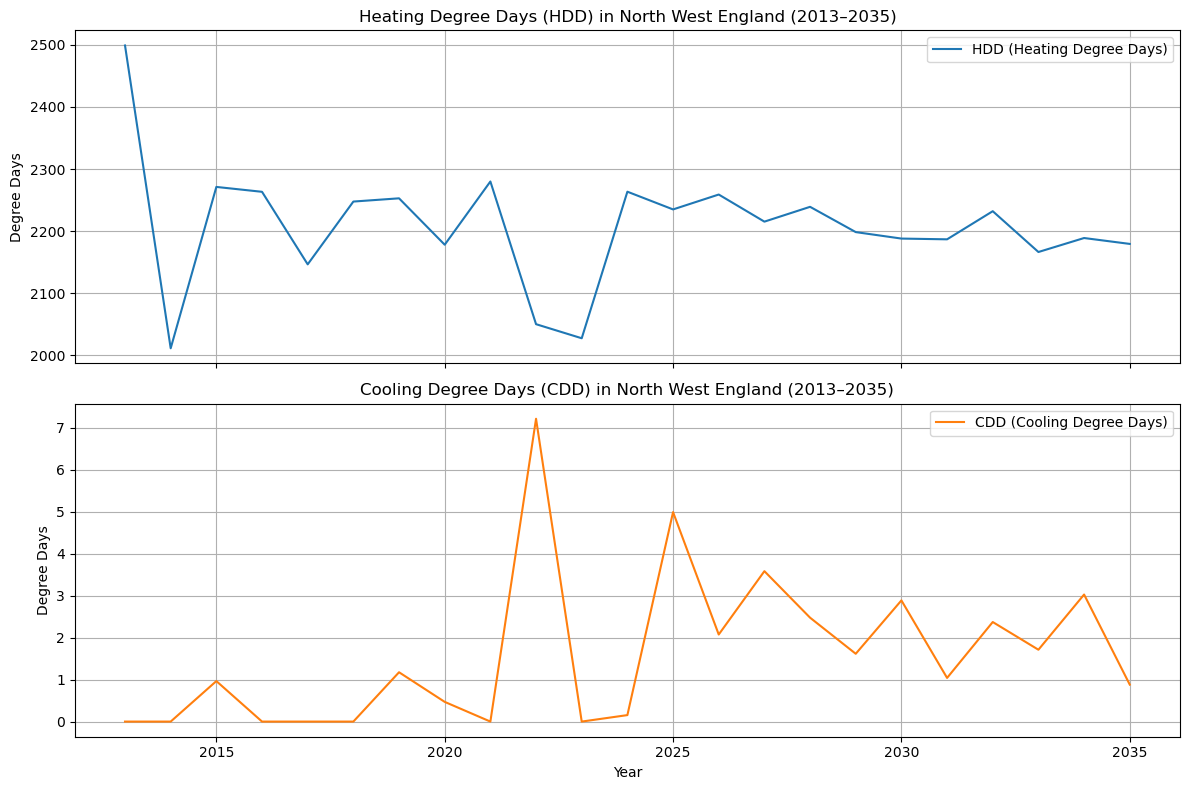

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# HDD submap
sns.lineplot(ax=axes[0], data=df_hdd_cdd, x='Year', y='HDD', color='tab:blue', label='HDD (Heating Degree Days)')
axes[0].set_ylabel('Degree Days')
axes[0].set_title('Heating Degree Days (HDD) in North West England (2013–2035)')
axes[0].grid(True)
axes[0].legend()

# CDD submap
sns.lineplot(ax=axes[1], data=df_hdd_cdd, x='Year', y='CDD', color='tab:orange', label='CDD (Cooling Degree Days)')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Degree Days')
axes[1].set_title('Cooling Degree Days (CDD) in North West England (2013–2035)')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

# Step2 Join LSTM series

In [12]:
df_lstm = pd.read_csv('df_lstm_multi_full.csv')
df_hdd_cdd.rename(columns={'Year': 'year'}, inplace=True)
df_merge = df_lstm.merge(df_hdd_cdd, on = 'year', how = 'left')
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   year                            230 non-null    int64  
 1   LOCAL_AUTHORITY                 230 non-null    object 
 2   ENERGY_CONSUMPTION_CURRENT_RAW  110 non-null    float64
 3   BUILDING_REFERENCE_NUMBER       110 non-null    float64
 4   population_RAW                  230 non-null    float64
 5   TOTAL_FLOOR_AREA_RAW            230 non-null    float64
 6   building_count                  230 non-null    float64
 7   HDD                             230 non-null    float64
 8   CDD                             230 non-null    float64
dtypes: float64(7), int64(1), object(1)
memory usage: 16.3+ KB


In [14]:
df_merge.to_csv('df_lstm_multi_with_hc.csv', index = False)

# Step3 Train LSTM (can be runned independently)

In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import tensorflow as tf
import random
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)
# fixed random seed for reproducibility

In [19]:
# deterministic mode (make sure no variance due to parallelism)
tf.config.experimental.enable_op_determinism()

In [21]:
df_full = pd.read_csv('df_lstm_multi_with_hc.csv')

In [23]:
features = [
    'ENERGY_CONSUMPTION_CURRENT_RAW',
    'building_count',
    'population_RAW',
    'TOTAL_FLOOR_AREA_RAW',
    'HDD',
    'CDD'
]
n_steps = 3
forecast_years = list(range(2024, 2036))
regions = df_full['LOCAL_AUTHORITY'].unique()

# creating sliding window sequence
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i: i + n_steps])
        y.append(data[i + n_steps][0])  # target is the first variable
    return np.array(X), np.array(y)

forecast_results = {}

# main loop: one model per region
for region in regions:
    df_region = df_full[df_full['LOCAL_AUTHORITY'] == region].sort_values('year').copy()
    df_hist = df_region[df_region['year'] <= 2023]
    df_future = df_region[df_region['year'] >= 2024]

    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df_hist[features])  # only historical data

    #  build series
    X, y = create_sequences(scaled, n_steps)
    X = X.reshape((X.shape[0], n_steps, len(features)))

    # build model
    model = Sequential([
        LSTM(64, activation='relu', input_shape=(n_steps, len(features))),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=100, verbose=0)

    # initial window：2021–2023
    all_scaled = scaler.transform(df_region[features])
    current_window = all_scaled[len(df_hist) - n_steps: len(df_hist)]

    predictions = []

    for i in range(len(df_future)):
        x_input = current_window.reshape((1, n_steps, len(features)))
        y_pred_scaled = model.predict(x_input, verbose=0)[0][0]

        next_row = all_scaled[len(df_hist) + i].copy()
        next_row[0] = y_pred_scaled  # replace energy with predicted results
        current_window = np.vstack([current_window[1:], next_row])

        dummy = np.zeros((1, len(features)))
        dummy[0] = next_row
        energy_unscaled = scaler.inverse_transform(dummy)[0][0]
        predictions.append(energy_unscaled)

    forecast_results[region] = predictions
    
# show result of one region
for region, preds in forecast_results.items():
    print(f'\nPredictions for {region} (2024-2035):')
    for year, val in zip(forecast_years, preds):
        print(f'{year}: {val: 2f} kWh/m2')
    break

D:\01azb\realAnaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
D:\01azb\realAnaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
D:\01azb\realAnaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
D:\01azb\realAnaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to


Predictions for E08000001 (2024-2035):
2024:  235.006401 kWh/m2
2025:  229.995219 kWh/m2
2026:  229.220486 kWh/m2
2027:  227.043463 kWh/m2
2028:  221.525599 kWh/m2
2029:  223.697919 kWh/m2
2030:  223.872059 kWh/m2
2031:  223.842977 kWh/m2
2032:  225.089158 kWh/m2
2033:  223.663739 kWh/m2
2034:  224.547807 kWh/m2
2035:  221.572485 kWh/m2


In [25]:
# save results
df_predictions = pd.DataFrame([
    {'year': year, 'LOCAL_AUTHORITY': region, 'predicted_energy': energy}
    for region, values in forecast_results.items()
    for year, energy in zip(forecast_years, values)
])

df_predictions = df_predictions.sort_values(by = ['LOCAL_AUTHORITY', 'year']).reset_index(drop = True)

df_predictions.to_csv("lstm_hdd_cdd_predicted_energy_2024_2035.csv", index = False)

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
df_predictions = pd.read_csv("lstm_hdd_cdd_predicted_energy_2024_2035.csv", dtype={
    "year": str,
        "LOCAL_AUTHORITY": str,
        "predicted_energy": float
    },
    keep_default_na=False
)

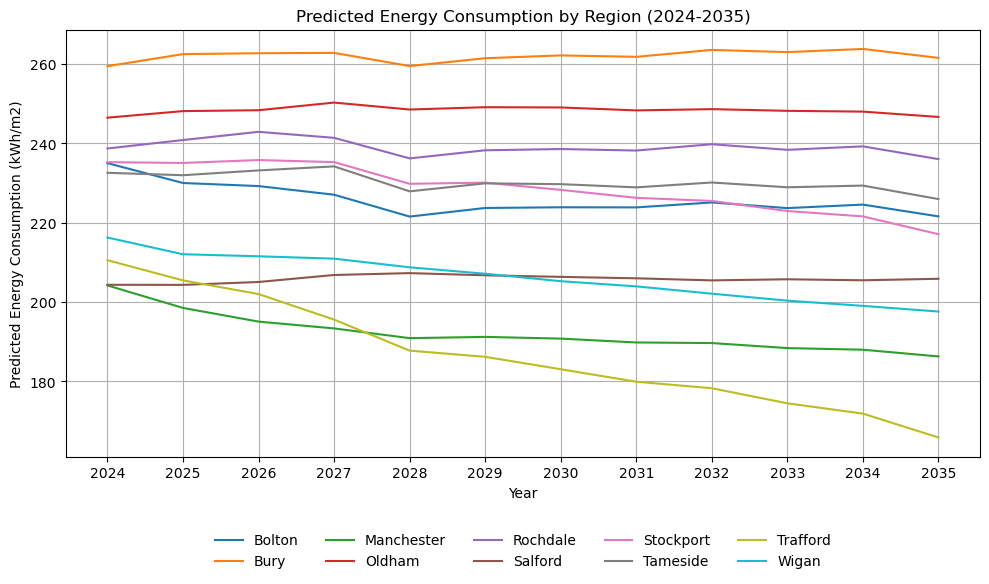

In [29]:
la_name_map = {
    "E08000001": "Bolton",
    "E08000002": "Bury",
    "E08000003": "Manchester",
    "E08000004": "Oldham",
    "E08000005": "Rochdale",
    "E08000006": "Salford",
    "E08000007": "Stockport",
    "E08000008": "Tameside",
    "E08000009": "Trafford",
    "E08000010": "Wigan"
}

plt.figure(figsize = (10, 6))

for region in df_predictions['LOCAL_AUTHORITY'].unique():
    df_region = df_predictions[df_predictions['LOCAL_AUTHORITY'] == region]
    region_name = la_name_map.get(region, region)
    plt.plot(df_region['year'], df_region['predicted_energy'], label=region_name)

plt.title('Predicted Energy Consumption by Region (2024-2035)')
plt.xlabel('Year')
plt.ylabel('Predicted Energy Consumption (kWh/m2)')

plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=5,
    frameon=False
)

plt.grid(True)
plt.tight_layout()
plt.show()

# Step4 Total energy consumption

In [32]:
# toal= energy unit area*total area
df_full = pd.read_csv("df_lstm_multi_with_hc.csv")
df_predictions = pd.read_csv("lstm_hdd_cdd_predicted_energy_2024_2035.csv")

df_full = df_full.merge(df_predictions, on=["year", "LOCAL_AUTHORITY"], how="left")

df_full["predicted_total_energy"] = df_full["predicted_energy"] * df_full["TOTAL_FLOOR_AREA_RAW"]
df_full.to_csv("df_lstm_with_hdd_cdd_total_energy_forecast.csv", index=False)

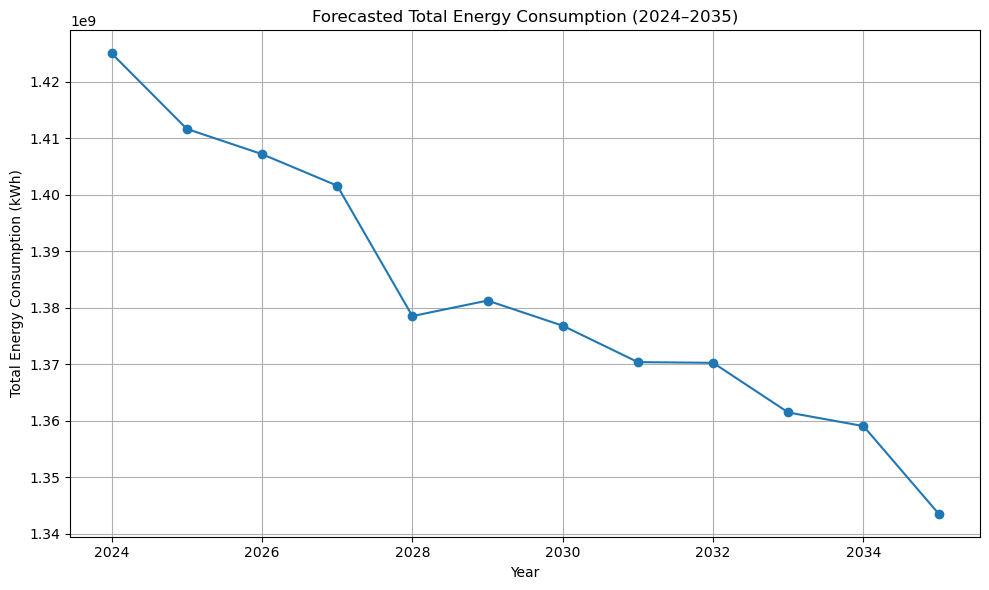

In [34]:
import matplotlib.pyplot as plt

# future year
df_future = df_full[df_full["year"] >= 2024]

# aggregate
yearly_total = df_future.groupby("year")["predicted_total_energy"].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(yearly_total["year"], yearly_total["predicted_total_energy"], marker="o")
plt.title("Forecasted Total Energy Consumption (2024–2035)")
plt.xlabel("Year")
plt.ylabel("Total Energy Consumption (kWh)")
plt.grid(True)
plt.tight_layout()
plt.show()

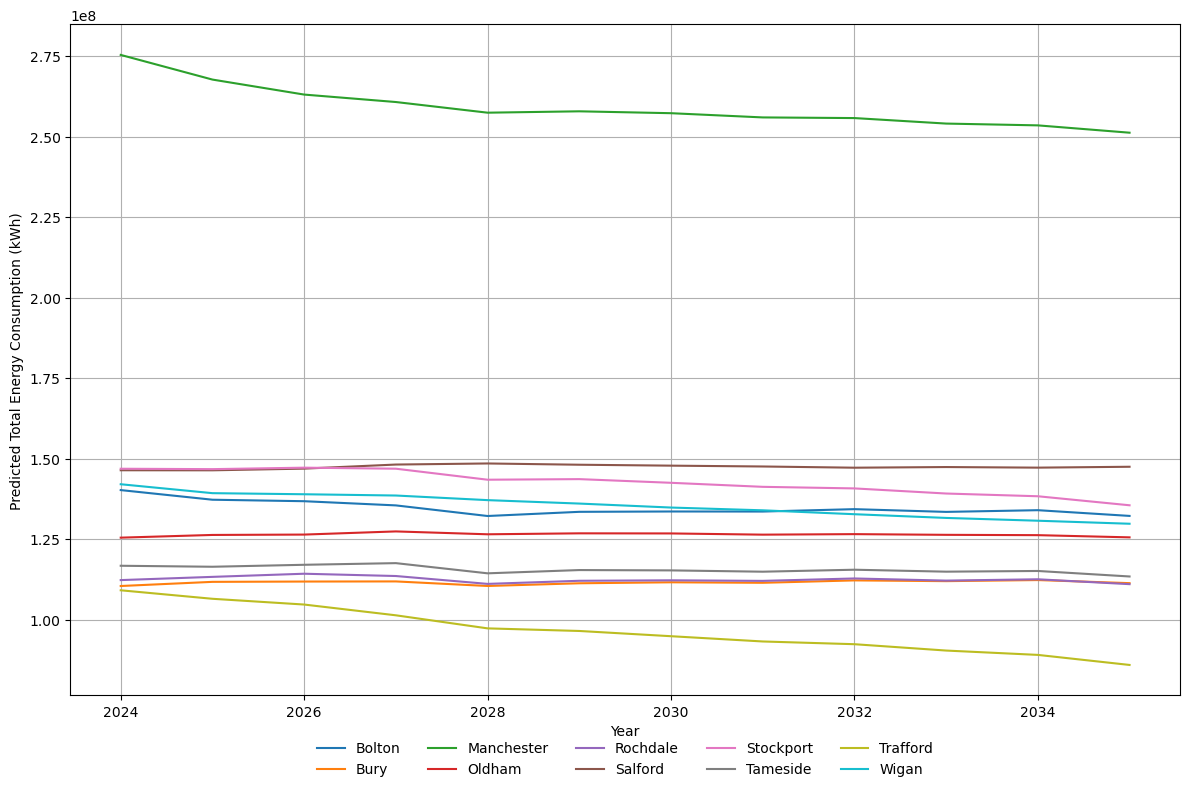

In [36]:
# regional yearly maps
la_name_map = {
    "E08000001": "Bolton",
    "E08000002": "Bury",
    "E08000003": "Manchester",
    "E08000004": "Oldham",
    "E08000005": "Rochdale",
    "E08000006": "Salford",
    "E08000007": "Stockport",
    "E08000008": "Tameside",
    "E08000009": "Trafford",
    "E08000010": "Wigan"
}
df_forecast = df_full[(
    df_full["year"] >= 2024) & (df_full["year"] <= 2035) & (df_full["predicted_total_energy"].notna())].copy()
# Plot
plt.figure(figsize=(12, 8))
for la in df_forecast["LOCAL_AUTHORITY"].unique():
    d = df_forecast[df_forecast["LOCAL_AUTHORITY"] == la].sort_values("year")
    label = la_name_map.get(la, la)
    plt.plot(d["year"], d["predicted_total_energy"], label=label)

plt.xlabel("Year")
plt.ylabel("Predicted Total Energy Consumption (kWh)")

# Legend below, multiple columns
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=5, frameon=False)

plt.grid(True)
plt.tight_layout()

plt.show()